In [1]:
from helpers.data_handler import *
from helpers.plot import *
from tqdm.notebook import tqdm

In [2]:
# config for each dataset
koesterich_config = {'name': 'koesterich',
                'filepath': 'data_processed/koesterich.csv',
                'evaluated': 'data_evaluated/koesterich.csv',
                'seed': 0,
                'col1': 'length',
                'col2': 'plural_match',
                'humans': {
                    'long, plural match': 0.49, 'long, plural mismatch': 0.84,
                    'short, plural match': 0.51, 'short, plural mismatch': 0.82}
                }
ness_config = {'name': 'ness',
                'filepath': 'data_processed/ness.csv',
                'evaluated': 'data_evaluated/ness.csv',
                'seed': 0,
                'col1': 'dependency',
                'col2': 'match',
                'humans': {'F-G, animacy match': 0.69, 'F-G, animacy mismatch': 0.75,
                           'S-V, animacy match': 0.76, 'S-V, animacy mismatch': 0.77}}

datasets = {'koesterich': koesterich_config, 'ness': ness_config}

In [10]:
# set evaluation mode
eval_mode = False

# choose dataset
dataset = datasets['koesterich']

## Evaluate Data

In [11]:
if eval_mode is True:
    df = load_data(dataset['filepath'])
    
    # Initialize the list of accuracies
    seed = dataset['seed']
    list_of_checkpoints = get_checkpoints(seed=dataset['seed'])
    
    # Predict the masked token for each checkpoint
    for checkpoint in tqdm(list_of_checkpoints):
        pt_model = load_model_and_tokenizer(checkpoint)
        df = predict_masked_token_for_df(df, pt_model, checkpoint)
        
    df.to_csv(dataset['evaluated'])

## Analyze Evaluated Data

In [12]:
# load data after evaluation
df = pd.read_csv(dataset['evaluated'])
list_of_checkpoints = get_checkpoints(seed=dataset['seed'])

In [13]:
df.head()

,Unnamed: 0,prompt,label1,label2,distractor1,distractor2,length,plural_match,predicted_token0k,label_prob0k,...,distractor_prob1900k,diff_prob1900k,top_prob1900k,correct1900k,predicted_token2000k,label_prob2000k,distractor_prob2000k,diff_prob2000k,top_prob2000k,correct2000k
0,0,The tourist hired the guides that the locals a...,guides,guides,tourist,tourist,short,mismatch,guides,0.678658,...,0.998187,-0.996374,tourist,False,tourist,0.001257,0.998743,-0.997486,tourist,False
1,1,The tourists hired the guides that the locals ...,guides,guides,tourists,tourists,short,match,tourists,0.445800,...,0.991816,-0.983632,tourists,False,tourists,0.007373,0.992627,-0.985254,tourists,False
2,2,The tourist hired the guides that two days ago...,guides,guides,tourist,tourist,long,mismatch,guides,0.574520,...,0.999052,-0.998103,tourist,False,tourist,0.000649,0.999351,-0.998703,tourist,False
3,3,The tourists hired the guides who two days ago...,guides,guides,tourists,tourists,long,match,guides,0.532627,...,0.985216,-0.970433,tourists,False,tourists,0.012928,0.987073,-0.974145,tourists,False
4,4,The coach removed the gymnasts that the fans d...,gymnasts,gymnasts,coach,coach,short,mismatch,coach,0.440403,...,0.722719,-0.445439,coach,False,coach,0.121301,0.878699,-0.757398,coach,False


In [14]:
# data cleaning
if dataset['name'] == 'ness':
    df['match'] = df['match'].replace({True: 'animacy match', False: 'animacy mismatch'})
elif dataset['name'] == 'koesterich':
    df['plural_match'] = df['plural_match'].replace({'match': 'plural match', 'mismatch': 'plural mismatch'})

## Plots metrics

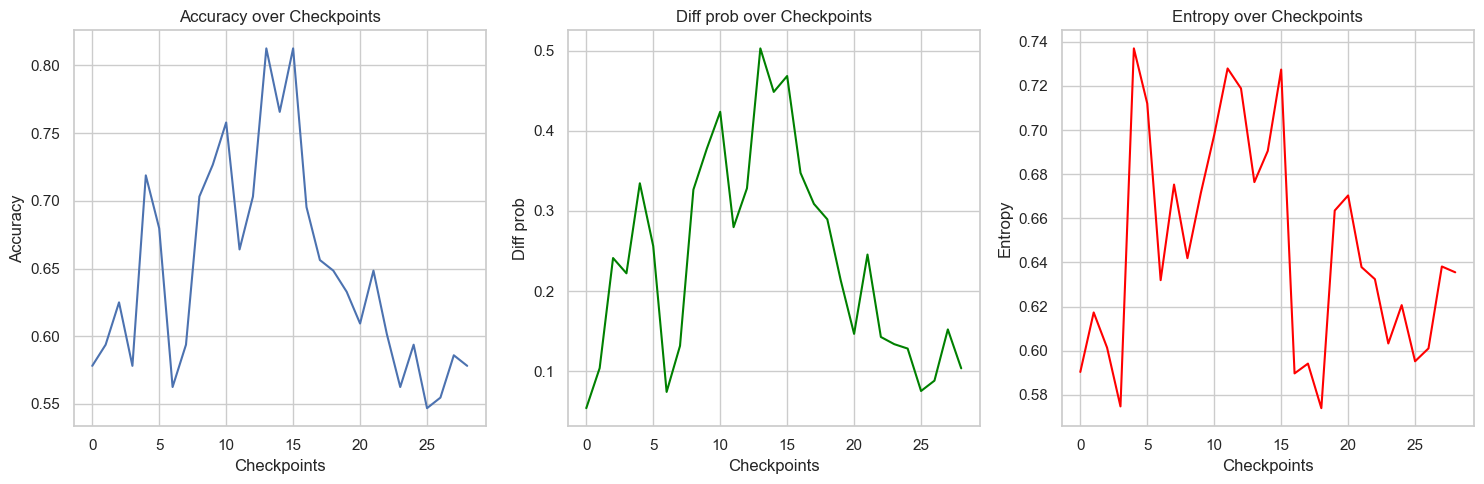

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set_theme(style="whitegrid")

correct_cols = [col for col in df.columns if 'correct' in col]
diff_prob_cols = [col for col in df.columns if 'diff_prob' in col]

acc = df[correct_cols].mean(axis=0)
diff = df[diff_prob_cols].mean(axis=0)
entropy = df_entropy(df[diff_prob_cols])

steps = np.arange(len(list_of_checkpoints))

# Plot Accuracy with blue color
axes[0].set_title("Accuracy over Checkpoints")
axes[0].set_xlabel("Checkpoints")
axes[0].set_ylabel("Accuracy")
sns.lineplot(x=steps, y=acc, ax=axes[0])

# Plot Diff prob with green color
axes[1].set_title("Diff prob over Checkpoints")
axes[1].set_xlabel("Checkpoints")
axes[1].set_ylabel("Diff prob")
sns.lineplot(x=steps, y=diff, ax=axes[1], color='green')

# Plot Entropy with red color
axes[2].set_title("Entropy over Checkpoints")
axes[2].set_xlabel("Checkpoints")
axes[2].set_ylabel("Entropy")
sns.lineplot(x=steps, y=entropy, ax=axes[2], color='red')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


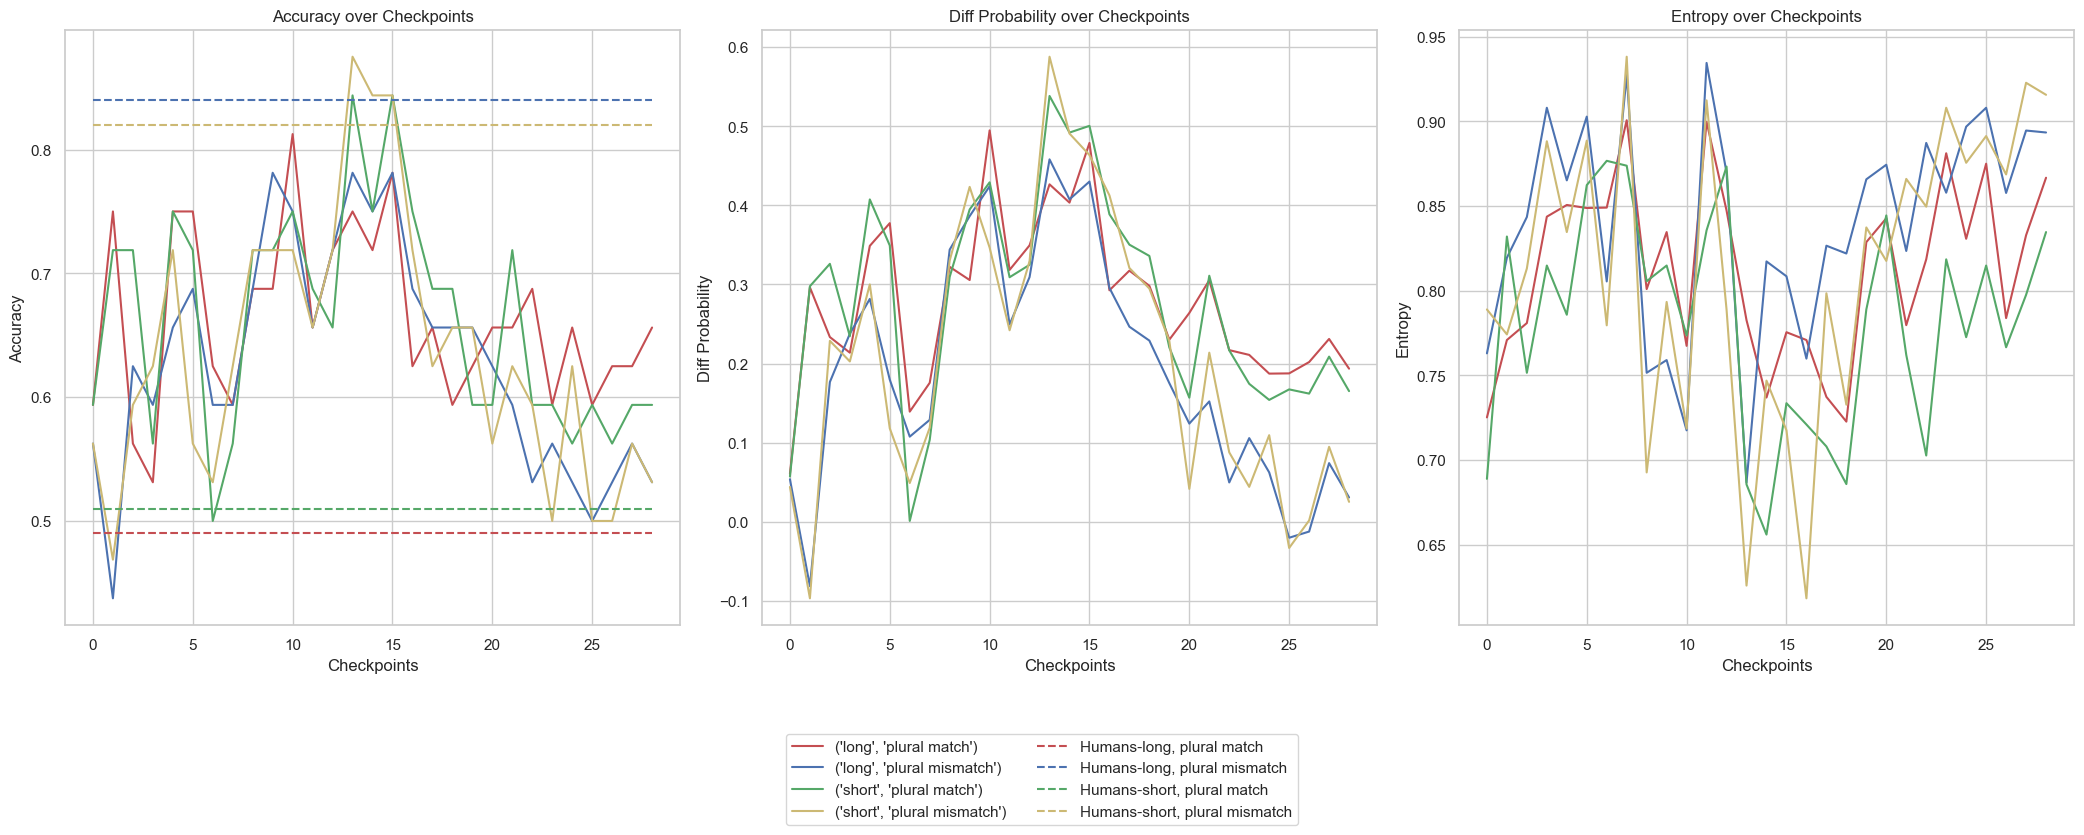

In [16]:
num_of_checkpoints = len(list_of_checkpoints)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
sns.set_theme(style="whitegrid")

# For the first subplot
plot_on_subplot(df, dataset['col1'], dataset['col2'], 'acc', "Accuracy over Checkpoints", "Checkpoints", "Accuracy", num_of_checkpoints, axes[0], humans=dataset['humans'])

# For the second subplot
plot_on_subplot(df, dataset['col1'], dataset['col2'], 'diff_prob', "Diff Probability over Checkpoints", "Checkpoints", "Diff Probability", num_of_checkpoints, axes[1])

# For the third subplot
plot_on_subplot(df, dataset['col1'], dataset['col2'], 'entropy', "Entropy over Checkpoints", "Checkpoints", "Entropy", num_of_checkpoints, axes[2])

handles, labels = axes[0].get_legend_handles_labels() 
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout()
plt.show()